# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Loading LSTM

In [ ]:
model = load_model(r'/content/drive/My Drive/Model Files/Fixed_CombinedModel_50e_300units.h5')

In [ ]:
X_test = np.load(r'/content/drive/My Drive/Model Files/Full_NP_X_test.npy')
y_test = np.load(r'/content/drive/My Drive/Model Files/Full_NP_y_test.npy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(1, 5, 299, 299, 3)]     0         
                                                                 
 time_distributed_1 (TimeDi  (1, 5, 8, 8, 2048)        21802784  
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (1, 5, 2048)              0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (1, 5, 300)               2818800   
                                                                 
 time_distributed_3 (TimeDi  (1, 5, 94)                28294     
 stributed)                                                      
                                                             

# DCT Loading

In [ ]:
model = load_model(r'/content/drive/My Drive/Model Files/Separated_BiDirectional_DCT_300.h5')

In [ ]:
X_test = np.load(r'/content/drive/My Drive/Model Files/X_test_300_cropped_dct.npy')
y_test = np.load(r'/content/drive/My Drive/Model Files/y_test_300_cropped_dct.npy')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (1, 5, 4096)              66748416  
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDi  (1, 5, 94)                385118    
 stributed)                                                      
                                                                 
Total params: 67133534 (256.09 MB)
Trainable params: 67133534 (256.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# BiLSTM Loading

In [ ]:
model = load_model(r'/content/drive/My Drive/Model Files/Separated_BiDirectional.h5')

In [ ]:
X_test = np.load(r'/content/drive/My Drive/Model Files/X_test.npy')
y_test = np.load(r'/content/drive/My Drive/Model Files/y_test.npy')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 4096)           67125248  
 al)                                                             
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 94)             385118    
 stributed)                                                      
                                                                 
Total params: 67510366 (257.53 MB)
Trainable params: 67510366 (257.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Performance Metrics

In [ ]:
num_classes = 94
y_test_ohe = np.zeros((y_test.shape[0], y_test.shape[1], num_classes), dtype=np.int32)
for i in range(y_test.shape[0]):
    y_test_ohe[i] = to_categorical(y_test[i], num_classes=num_classes)

## RAM efficient (use for InceptionV3 + LSTM)

In [ ]:
# prepare input by adding batch_size and convert from float64 to float32
def float_data_generator():
    for i in range(len(X_test)):
        seq = np.expand_dims(X_test[i], axis=0)
        seq = seq.astype(np.float32)
        yield seq, y_test[i]

In [ ]:
def float_data_generator(X_test, y_test, batch_size=32):
    num_samples = len(X_test)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_X = X_test[offset:offset+batch_size]
            batch_y = y_test[offset:offset+batch_size]
            batch_X = np.array(batch_X).astype(np.float32)
            yield batch_X, batch_y

batch_size = 32
generator = float_data_generator(X_test, y_test, batch_size=batch_size)
num_batches = len(X_test) // batch_size

y_pred = []
for _ in range(num_batches):
    X_batch, _ = next(generator)
    y_pred_prob = model.predict(X_batch)
    y_pred_batch = np.argmax(y_pred_prob, axis=2)
    y_pred.extend(y_pred_batch)

# When samples are not divisible by batch_size
if len(X_test) % batch_size != 0:
    X_batch, _ = next(generator)
    y_pred_prob = model.predict(X_batch)
    y_pred_batch = np.argmax(y_pred_prob, axis=2)
    y_pred.extend(y_pred_batch[:len(X_test) % batch_size])

y_pred = np.array(y_pred)


1/1 [==============================] - 13s 13s/step


In [ ]:
y_pred.shape

(1842, 5)

## Confusion Matrix

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=2)

58/58 [==============================] - 2s 18ms/step


In [ ]:
y_pred_ohe = np.zeros((y_pred.shape[0], y_pred.shape[1], num_classes), dtype=np.int32)
for i in range(y_pred.shape[0]):
    y_pred_ohe[i] = to_categorical(y_pred[i], num_classes=num_classes)

In [ ]:
# Reshape y_test_ohe and y_pred_ohe into one-dimensional arrays
y_test_flat = y_test_ohe.reshape(-1, num_classes)
y_pred_flat = y_pred_ohe.reshape(-1, num_classes)

In [ ]:
# Metrics for all 5
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat, average='weighted')
recall = recall_score(y_test_flat, y_pred_flat, average='weighted')
f1 = f1_score(y_test_flat, y_pred_flat, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8284473398479913
Precision: 0.8543721148234774
Recall: 0.8284473398479913
F1-score: 0.8354243730960365


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# Metrics for non-padded / actual sentence lengths

total_labels = 0
correct_count = 0
pred_list = []
exp_list = []

sen_idx = -1
for real, pred in zip(y_test_ohe, y_pred_ohe):
  sen_idx += 1
  exp_seq = np.argmax(real, axis=1)
  original = exp_seq
  pred_seq = np.argmax(pred, axis=1)
  last = exp_seq[-1]

  i = 3

  while original[i] == last:
    exp_seq = exp_seq[:-1]
    pred_seq = pred_seq[:-1]
    i -= 1

  pred_list.append(pred_seq)
  exp_list.append(exp_seq)

In [ ]:
# Flatten the lists
flat_pred = [item for sublist in pred_list for item in sublist]
flat_exp = [item for sublist in exp_list for item in sublist]

# Create the confusion matrix
conf_matrix = confusion_matrix(flat_exp, flat_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[31  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 30  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 23]]


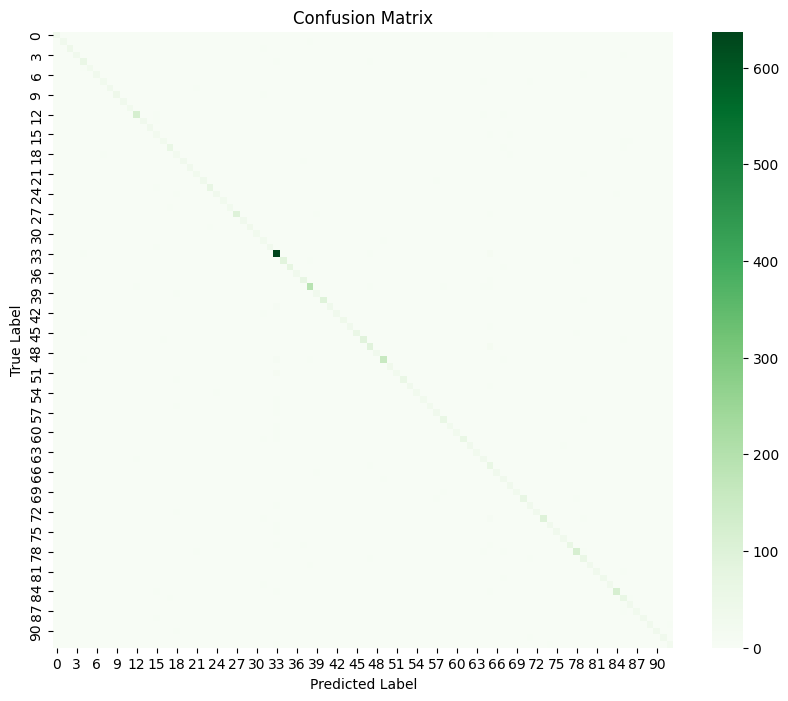

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Performance Metrics of real sentence lengths

accuracy = accuracy_score(flat_exp, flat_pred)
precision = precision_score(flat_exp, flat_pred, average='weighted')
recall = recall_score(flat_exp, flat_pred, average='weighted')
f1 = f1_score(flat_exp, flat_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8378661087866108
Precision: 0.8683899354532977
Recall: 0.8378661087866108
F1-score: 0.8463304080112198
